In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%pwd

u'/Users/travis/Documents/hackathons/tmobile-hackathon/notebooks'

In [7]:
import sklearn.model_selection as ms
import sklearn.linear_model as lm
import sklearn.ensemble as ens

## Collect and review data, eliminate columns which do not pertain to phone loans

In [105]:
loans = pd.read_csv('../data/loan.csv')

In [106]:
,'collections_12_mths_ex_med','mths_since_last_major_derog','policy_code','annual_inc_joint'
,'dti_joint','verification_status_joint','acc_now_delinq','tot_coll_amt','tot_cur_bal'
,'open_acc_6m','open_il_6m','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il'
,'il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util','total_rev_hi_lim'
,'inq_fi','total_cu_tl','inq_last_12m'

"'inq_fi','total_cu_tl','inq_last_12m'"

In [107]:
dropcols = ['id', 'member_id', 'funded_amnt_inv', 'grade', 'sub_grade', 'verification_status',
           'url', 'desc', 'title' , 'addr_state', 'dti', 'earliest_cr_line', 'inq_last_6mths',
            'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal'
           'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_pymnt',
           'total_pymnt_inv','total_rec_prncp', 'total_rec_int','total_rec_late_fee', 'recoveries',
            'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d',
            'last_credit_pull_d','collections_12_mths_ex_med','mths_since_last_major_derog','policy_code','annual_inc_joint'
            ,'dti_joint','verification_status_joint','acc_now_delinq','tot_coll_amt','tot_cur_bal'
            ,'open_acc_6m','open_il_6m','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il'
            ,'il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util','total_rev_hi_lim'
            ,'inq_fi','total_cu_tl','inq_last_12m'
                   ]
dropcols = set(dropcols)
keep_cols = []
for col in loans.columns:
    if col not in dropcols:
        keep_cols.append(col)

In [114]:
y_cols = ['delinq_2yrs']
# 'delinq_2yrs' The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

purpose_keeprows = ['small_business', 'credit_card', 'other']


loans_ = loans[keep_cols]
loans_clean = loans_[loans_['purpose'] == 'credit_card']
loans_clean.dropna(inplace=True)
loans_y = loans_clean.pop('delinq_2yrs')

## remove the word months from term
## change 'issue_d' to day of week or month to see if it helps

/Users/travis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [115]:
loans_y_bin = loans_y.apply(lambda x: 1 if x > 1 else 0)

## Clean data which remains make sure it's numeric, and add dummy variables where needed

In [116]:
# atonum = {l:n for n, l in enumerate('abcdefghijklmnopqrstuv'.upper())}

In [117]:
loans_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193647 entries, 13 to 887378
Data columns (total 19 columns):
loan_amnt              193647 non-null float64
funded_amnt            193647 non-null float64
term                   193647 non-null object
int_rate               193647 non-null float64
installment            193647 non-null float64
emp_title              193647 non-null object
emp_length             193647 non-null object
home_ownership         193647 non-null object
annual_inc             193647 non-null float64
issue_d                193647 non-null object
loan_status            193647 non-null object
pymnt_plan             193647 non-null object
purpose                193647 non-null object
zip_code               193647 non-null object
revol_bal              193647 non-null float64
initial_list_status    193647 non-null object
out_prncp              193647 non-null float64
out_prncp_inv          193647 non-null float64
application_type       193647 non-null object
dtypes

In [118]:
loans_clean_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193647 entries, 13 to 887378
Data columns (total 18 columns):
loan_amnt              193647 non-null float64
funded_amnt            193647 non-null float64
term                   193647 non-null object
int_rate               193647 non-null float64
installment            193647 non-null float64
emp_title              193647 non-null object
emp_length             193647 non-null object
home_ownership         193647 non-null object
annual_inc             193647 non-null float64
loan_status            193647 non-null object
pymnt_plan             193647 non-null object
purpose                193647 non-null object
zip_code               193647 non-null object
revol_bal              193647 non-null float64
initial_list_status    193647 non-null object
out_prncp              193647 non-null float64
out_prncp_inv          193647 non-null float64
application_type       193647 non-null object
dtypes: float64(8), object(10)
memory usage: 28.1+ M

In [176]:
loans_clean_ = loans_clean.copy()
loans_clean_['issue_d'] = loans_clean['issue_d'].apply(pd.Timestamp)
loans_clean_['year'] = loans_clean_['issue_d'].apply(lambda x: x.year)
loans_clean_['zip_code'] = loans_clean_['zip_code'].astype('category')
loans_clean_.drop(['application_type', 'purpose', 
                   'pymnt_plan', 'issue_d', 'loan_status'], axis=1, inplace=True)

In [177]:
rows_need_dummies = ['emp_title', 'initial_list_status', 
                     'home_ownership', 'emp_length', 'term', 'zip_code']

In [178]:
def make_dummy(df, cols):
    df_ = df.copy()
    for col in cols:
        for value in df[col].value_counts().nlargest(50).index:
            df_['{}_{}'.format(col, value)] = df[col] == value
        df_.drop(col, axis=1, inplace=True)
    return df_

In [179]:
loans_model = make_dummy(loans_clean_, rows_need_dummies)

## Train logistic regression Classifier

In [180]:
Xtr, Xte, ytr, yte = ms.train_test_split(loans_model, loans_y_bin, test_size= .15)

In [181]:
model = lm.LogisticRegression(max_iter=400,  C=.75, n_jobs=-1)

In [182]:
model.fit(Xtr, ytr)

LogisticRegression(C=0.75, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=400, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [201]:
probs = model.predict_proba(Xte)
probs = probs[:,1]

In [294]:
def generate_roc_curve(probs, yte, n_iter= 200):
    '''
    '''
    thres_list = np.linspace(0,1,n_iter)
#     thres_list = np.sqrt(thres_list)
    rocs = []
    test = yte.reshape(-1,1)
    proba = probs.reshape(-1,1)
    pframe = pd.DataFrame(np.append(proba, test, axis=1), columns= ['predict', 'label'])
    c_true = pframe[pframe['label'] == 1]
    c_false = pframe[pframe['label'] != 1]
    for thres in thres_list:
        tpr = float((c_true['predict'] > thres).sum()) / c_true.shape[0]
        fpr = float((c_false['predict'] > thres).sum()) / c_false.shape[0]
        rocs.append({'tpr' : tpr, 'fpr': fpr})
    return rocs

In [320]:
loans_clean_[out_prncp_inv].nlargest()

NameError: name 'out_prncp_inv' is not defined

In [299]:
rocs = generate_roc_curve(probs, yte, n_iter=2000)

In [300]:
colors = itertools.cycle(['green', 'red', 'cyan', 'orange', 'violet',
                          'yellow', 'blue', 'pink'])

2000


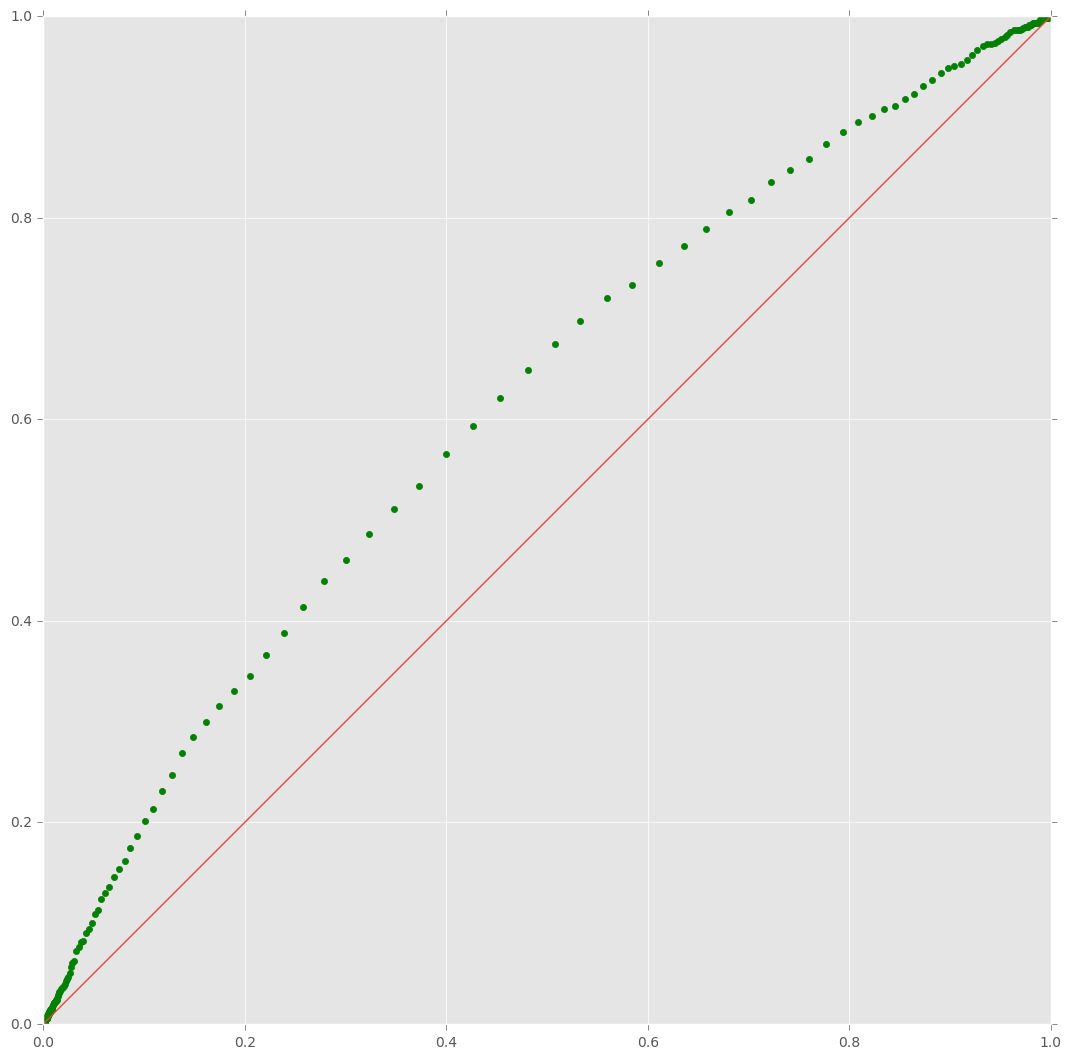

In [301]:
fig, ax = plt.subplots(1, 1, figsize=(13, 13))
fpr = []
tpr = []
for row in rocs:
    fpr.append(row['fpr'])
    tpr.append(row['tpr'])
print len(fpr)
ax.scatter(fpr, tpr, color=colors.next())
ax.plot(np.linspace(0,1,10), np.linspace(0,1,10))
ax.set_xlim(0,1)
ax.set_ylim(0,1)

fig.savefig('../images/1stROC.png')


In [317]:
col_vals = pd.DataFrame(model.coef_, columns=loans_model.columns)

In [314]:
col_vals.T

,0
loan_amnt,-4.627419e-04
funded_amnt,4.233388e-04
int_rate,5.550602e-04
installment,9.959149e-04
annual_inc,2.798749e-06
revol_bal,-1.155563e-05
out_prncp,3.004557e-04
out_prncp_inv,-2.792154e-04
year,-1.452733e-03
emp_title_Teacher,1.265106e-05
